# Ball on incline Data analysis
### Author: Søren Jefsen -- ktf752@alumni.ku.dk

### Packages used: numpy, matplotlib, minuit, scipy

#### !! SHOULD BE PUT IN THE SAME FOLDER AS THE .CSV DATA FROM BALL ON INCLINE EXPERIMENT

## Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys

## Functions from Troels

In [2]:
def nice_string_output(d, extra_spacing=5, decimals=3):
    """ 
    Takes a dictionary d consisting of names and values to be properly formatted.
    Makes sure that the distance between the names and the values in the printed
    output has a minimum distance of 'extra_spacing'. One can change the number
    of decimals using the 'decimals' keyword.  
    """
    
    names = d.keys()
    max_names = len_of_longest_string(names)
    
    values = values_to_string(d.values(), decimals=decimals)
    max_values = len_of_longest_string(values)
    
    string = ""
    for name, value in zip(names, values):
        spacing = extra_spacing + max_values + max_names - len(name) - 1 
        string += "{name:s} {value:>{spacing}} \n".format(name=name, value=value, spacing=spacing)
    return string[:-2]

def add_text_to_ax(x_coord, y_coord, string, ax, fontsize=12, color='k'):
    """ Shortcut to add text to an ax with proper font. Relative coords."""
    ax.text(x_coord, y_coord, string, family='monospace', fontsize=fontsize,
            transform=ax.transAxes, verticalalignment='top', color=color)
    return None

def len_of_longest_string(s):
    """ Returns the length of the longest string in a list of strings """
    return len(max(s, key=len))

def values_to_string(values, decimals):
    """ 
    Loops over all elements of 'values' and returns list of strings
    with proper formating according to the function 'format_value'. 
    """
    
    res = []
    for value in values:
        if isinstance(value, list):
            tmp = [format_value(val, decimals) for val in value]
            res.append(f'{tmp[0]} +/- {tmp[1]}')
        else:
            res.append(format_value(value, decimals))
    return res

def format_value(value, decimals):
    """ 
    Checks the type of a variable and formats it accordingly.
    Floats have 'decimals' number of decimals.
    """
    
    if isinstance(value, float):
        return f'{value:.{decimals}f}'
    elif isinstance(value, int):
        return f'{value:d}'
    else:
        return f'{value}'

#### General functions used throughout data analysis:

In [3]:
def fitting_function(t, a, v_0, x_0):                                  #The polynomial we are fitting with
    return 1/2 * a*t**2 + v_0*t + x_0

def chi2_owncalc(a, v_0, x_0):                                         #Chi2 calculation function
    y_fit = fitting_function(X, a, v_0, x_0)
    chi2 = np.sum(((gates - y_fit) / gates_sig)**2)
    return chi2

def weighted_average(data, sigma):
#######|DOCUMENTATION|#######
#Purpose: Finds the weighted average and its error from data. 
#Inputs: array of data and array of the corresponding error on this data
#Outputs: float of weighted average and float of error on this average
    
############|CODE|###########
    if type(sigma)== float or type(sigma) == int:                       #We convert to list, if just an integer or float
        sigma = [sigma for x in range(len(data))]
        
    if type(sigma) == list and len(sigma) == 1:
        sigma = [sigma[0] for x in range(len(data))]

    upper = sum([data[x]/(sigma[x]**2) for x in range(len(data))])       #sum of weigted datapoints
    lower = sum([1/(sigma[x]**2) for x in range(len(data))])             #normalized with sum of weights
    
    return upper/lower, np.sqrt(1/lower)                                 #Outputs weighted mean and error on it


def combine_errors(errors):                                              
########|DOCUMENTATION|##########
#Purpose: Combine an array of errors, by adding them squared
#Inputs: array of errors
#Outputs: float of combined error
    
##############|CODE|#############  
    if type(errors) == float or type(errors) == int:                     #We convert to list if just an integer or float
        errors = [errors]
    return np.sqrt(sum([x**2 for x in errors]))


def angle_extractor_2000(angles, sigma):     
##########|Documentation|########
#Calculates the mean and error on some nested data arrays from our measurements
#Inputs: array of array of angle measurements and some systematic error on these measurements
#Outputs: the weighted mean of all the measurements, and its error

#############|Code|##############
    output_mean = []                                        #Somewhere to store the data
    output_sig = []
    for k in angles:
        mean, std = weighted_average(k, sigma)              #Find the average and std of the two values
        std = np.std(k)
        sig = combine_errors([std, sigma])                  #Combine with measurement error
        output_mean.append(mean)
        output_sig.append(sig)

    return weighted_average(output_mean, output_sig)        #Combine all

## Loading data, and finding values around certain thresholds

In [4]:
data = [np.loadtxt(str(x+1) + ".csv", delimiter = ",").T for x in range(10)]   #import data from .csv file


def threshold_finder(data, thresh):

#########|DOCUMENTATION|###########
# Input: (data, threshold values)      with data = list, threshold values = float, int, or list
# Input data is two dimensional [[time_array], [voltage_array]]. Threshhold is just a list. 
# Oututs arrays as example [[low thresh], [mid thresh]  , ...] 
#      with [low thresh] = [[from peak 1], [from peak 2], ...]
#      and  [from peak 1]= [T_peak1, V_peak1]

############|CODE|#################
    if type(thresh) == int or type(thresh) == float:             #Correction, so the funciton works for single thresholds
        thresh = [thresh]
        
    T, V = data                                                  #We extract the data, and make somewhere to store it
    output = [[], [], []]

    for i in range(len(T)-1):                                    #We look at all datapoints
        
        #We check each boundary
        for b in thresh:
            b_index = np.where(np.array(thresh) == b)[0][0]
                                                                 #Check for two points, where one is lower and one is
            if V[i] < b and V[i+1] > b:                          #higher than the threshold
                if np.abs(V[i] - b) < np.abs(V[i+1]-b):
                    output[b_index].append([T[i], V[i]])         #And we pick the datapoint with the least distance
                                                                 #from the threshold (we have now found the point closest
                if np.abs(V[i] - b) > np.abs(V[i+1]-b):          #to the threshold
                    output[b_index].append([T[i+1], V[i+1]])
            
    return output

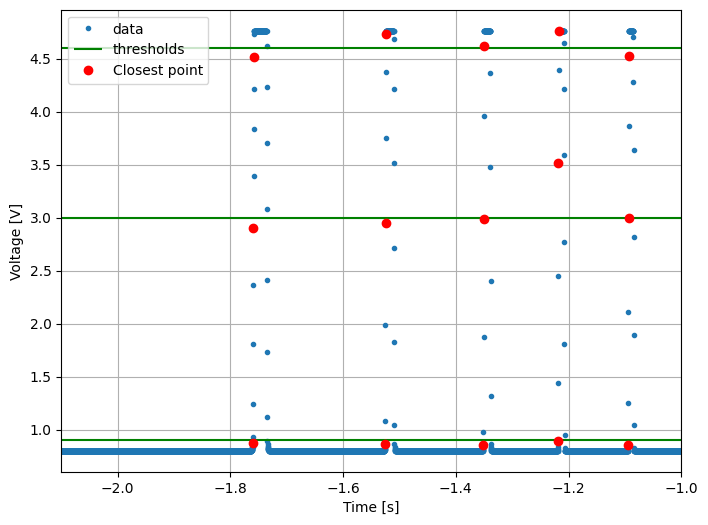

In [101]:
boundaries = [0.9, 3, 4.6]                                                   #The boundaries we want to find the closest point to

thresholds = [threshold_finder(run, boundaries) for run in data]             #We run the function on all data runs

fig, ax = plt.subplots(5, 2, figsize = (12,10), sharey=True)                 #And plot it all
ax = ax.flatten()

for i in range(len(data)):                                                   #This is kindof a mess, but it works. 
    ax[i].hlines(boundaries, -2, 1, color = "green", label = "thresholds")
    ax[i].plot(*data[i], '.', label = "Data")
    count = 0                                                                #This keeps track, so we dont crowd the legend box.
    for b in thresholds[i]:
        for t in b:
            if count == 0:
                ax[i].plot(*t, 'o', color = "red", label = "Closest point")
                count += 1
            else:
                ax[i].plot(*t, 'o', color = "red")
    ax[i].grid()
    ax[i].legend(fontsize = "small")
  
plt.close()

##########EXAMPLE PLOT##############
plt.figure(figsize = (8, 6))
plt.plot(*data[0], '.', label = "data")
plt.hlines(boundaries, -3, -1, color = "green", label = "thresholds")
plt.plot(*np.array(thresholds[0][0]).T, 'o', color = "red", label = "Closest point")
plt.plot(*np.array(thresholds[0][1]).T, 'o', color = "red")
plt.plot(*np.array(thresholds[0][2]).T, 'o', color = "red")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.grid()
plt.xlim(-2.1, -1)
plt.legend(loc = "upper left")

## Finding the location and sigma of the middle peaks

In [6]:
peaks = []                                                   #Somewhere to store our data for all runs
peaks_sig = []
for run in thresholds:                                       #somewhere to store our data for the single run
    mean = [x[0] for x in run[1]]
    low = []
    high = []
    
    for i in range(len(run[0])):                             #We extract the low and high peak values
        low = run[0][i][0]
        high = run[2][i][0]
        sig = np.abs(low-high)                               #And find the sigma as the difference of these

    peaks.append(mean - min(mean))                           #We substract the min value, to get T starting from 0
    peaks_sig.append(sig)

peaks = np.array(peaks)                                      #Convert to numpy arrays
peaks_sig = np.array(peaks_sig)

## Gate measurements

In [7]:
gates_r = [226, 386, 556, 722, 901] #mm
gates_a = [215.5, 381, 558, 722, 900.5] #mm                              # length to Gate 1, gate 2, ... etc
gates_m = [215.5, 381.5, 557.5, 722.5, 901] #mm
gates_s = [215.5, 383.0, 557.5, 722.0, 901] #mm
gates_measurement_sig = 0.5                                              #measurement error

gates_raw = np.array([gates_r, gates_a, gates_m, gates_s]).T             #Put it together in a matrix

gates = np.array([np.mean(x) for x in gates_raw])                        #find the mean values and their errors
gates -= min(gates)                                                      #We also correct so we start at x=0.
gates_sig = np.array([np.sqrt(np.std(x)**2 + gates_measurement_sig**2) 
                      for x in gates_raw])                               #Combine measurement and statistical error

gates = gates/1000                                                       #Convert to meters
gates_sig = gates_sig/1000

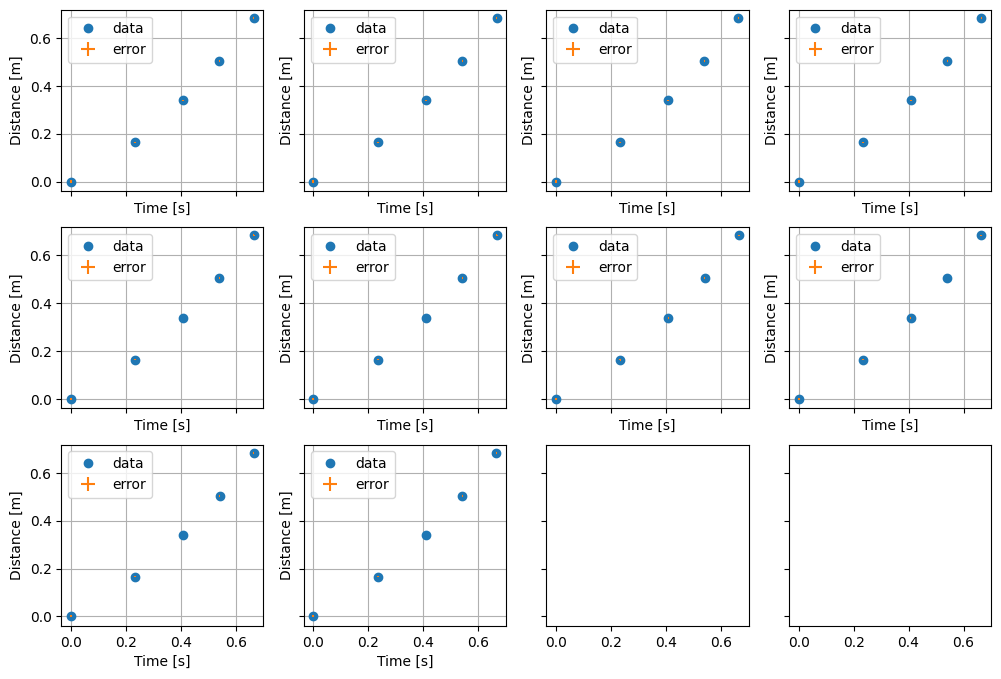

In [93]:
#############LETS PLOT IT##########
fig, ax = plt.subplots(3, 4, sharey = True, sharex = True, figsize = (12,8))
ax = ax.flatten()
for i in range(len(peaks)):
    ax[i].plot(peaks[i], gates, 'o', label = "data")
    ax[i].errorbar(peaks[i], gates, yerr = gates_sig, xerr = peaks_sig[i], linestyle = "", label = "error")
    ax[i].set_ylabel("Distance [m]")
    ax[i].set_xlabel("Time [s]")

    ax[i].grid()
    ax[i].legend()
#plt.close()


# Time for fitting

In [9]:
from iminuit import Minuit      

In [102]:
a_fit = []                                                           #Somewhere to store the data
a_fit_sig = []
v_fit = []
v_fit_sig = []
x_fit = []
x_fit_sig = []
chi2_fit = []
prob_fit = []

print_fit = False                                                    #Prints parameters and errors if True
Ndof = 5-3


for k in range(len(peaks)):
    X = peaks[k]                                                     #X the x values used in fitting function
    
    minuit_chi2 = Minuit(chi2_owncalc, a=1.5, v_0 = 1, x_0 = 0)      #Perform the fit
    minuit_chi2.errordef = 1.0
    minuit_chi2.migrad()
    chi2_val = minuit_chi2.fval
    prob = stats.chi2.sf(chi2_val, Ndof)
    
    if print_fit:
        print("run " + str(k) + " parameters")
    for name in minuit_chi2.parameters :
        value, error = minuit_chi2.values[name], minuit_chi2.errors[name]      #Extract parameters
        if print_fit:
            print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")
            
        if name == "a":                                                        #Extract parameters
            a_fit.append(value)
            a_fit_sig.append(error)
        if name == "v_0":
            v_fit.append(value)
            v_fit_sig.append(error)
        if name == "x_0":
            x_fit.append(value)
            x_fit_sig.append(error)


    chi2_fit.append(chi2_val)

    prob_fit.append(prob)
            
    if print_fit:     
        print("")
        
        
a_estimate, a_sig = weighted_average(a_fit, a_fit_sig)                        #Take a weighted average over all runs
print("Estimate of a")
print(a_estimate, a_sig)
print("")
print("chi2 values")
print(chi2_fit)
print("")

Estimate of a
1.5266338266972748 0.009562356776964754

chi2 values
[0.23146068242409848, 0.37200287592985487, 0.43306012316643133, 0.3555251648298695, 0.27219161271869136, 0.2544075377850495, 0.22339982065673453, 0.4274756253048695, 0.2892354355596467, 0.3691657007925514]



## Lets plot the fit

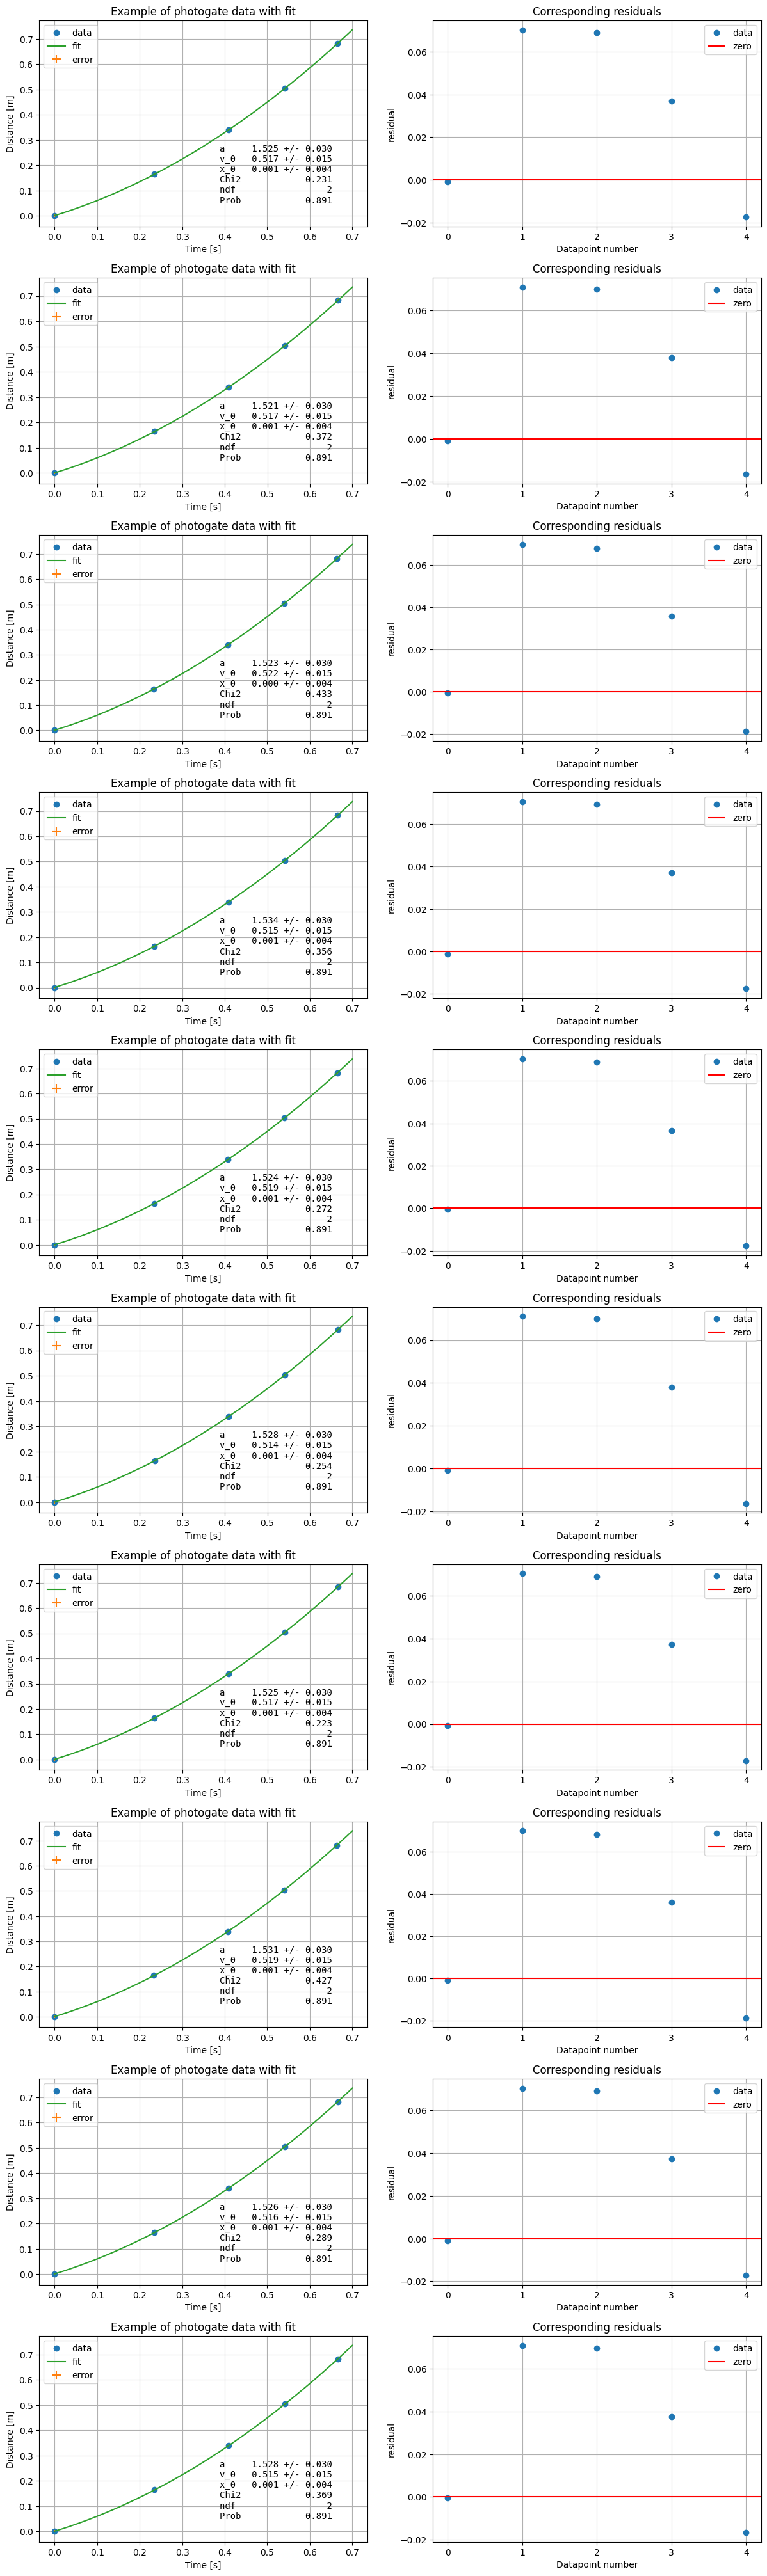

In [106]:
N_plots = 10                                #How many of the fits we want to plot (max 10)
res_list = []
fig, ax = plt.subplots(N_plots, 2, sharey = False, sharex = False, figsize = (12,4*N_plots))    #Setup figure
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.25)
for i in range(N_plots):
    #Plot the data and its errorbars
    ax[i][0].set_title("Example of photogate data with fit")
    ax[i][0].plot(peaks[i], gates, 'o', label = "data")
    ax[i][0].errorbar(peaks[i], gates, yerr = gates_sig, xerr = peaks_sig[i], linestyle = "", label = "error")
    ax[i][0].set_ylabel("Distance [m]")
    ax[i][0].set_xlabel("Time [s]")

    #the parameters of the fit
    d = {'a':       [a_fit[i], a_fit_sig[i]],
         'v_0':     [v_fit[i], v_fit_sig[i]],
         'x_0':     [x_fit[i], x_fit_sig[i]],
         'Chi2':     chi2_fit[i],
         'ndf':      Ndof,
         'Prob':     prob_fit[0],
    }
    
    X = np.linspace(0,0.7, 10000)                                  #PLots the fit line
    Y = fitting_function(X, a_fit[i], v_fit[i], x_fit[i])
    ax[i][0].plot(X,Y, label = "fit") 

    
    text = nice_string_output(d, extra_spacing=2, decimals=3)      #"plot" the parameters on the figure
    add_text_to_ax(0.55, 0.4, text, ax[i][0], fontsize=10)

    res = peaks[i]-fitting_function(peaks[i], a_fit[i], v_fit[i], x_fit[i])         #Calculate the residuals and plot them
    res_list.append(res)
    ax[i][1].set_title("Corresponding residuals")
    ax[i][1].plot(res, 'o', label = "data")
    ax[i][1].hlines(0, -1, 5, color = "red", label = "zero")
    ax[i][1].set_xlabel("Datapoint number")
    ax[i][1].set_xticks([0, 1, 2, 3, 4])
    ax[i][1].set_ylabel("residual")
    ax[i][1].legend()
    ax[i][1].grid()
    ax[i][1].set_xlim(-0.2, 4.2)
    
    ax[i][0].legend(loc='lower right', fontsize=10); 
    ax[i][0].grid()
    ax[i][0].legend()

#plt.close()

[-0.00077737  0.07047654  0.06910122  0.03706074 -0.01741007]
[0.0001774  0.00047508 0.0006526  0.00073691 0.00081385]


<ErrorbarContainer object of 3 artists>

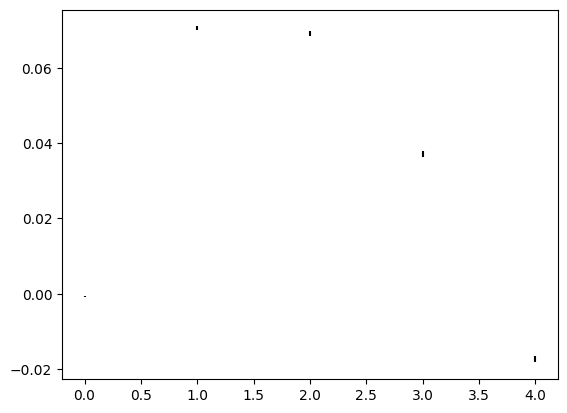

In [120]:
#THIS IS SOME TEST THING WITH THE AVERAGE RESIDUALS. WE SEE THAT THEY VARY VERY LITTLE
thing = np.array(res_list).T
avg = np.array([np.mean(x) for x in thing])
sig = np.array([np.std(x) for x in thing])
print(avg)
print(sig)
plt.errorbar([0, 1, 2, 3, 4], avg, yerr = sig, linestyle = "", color ="black")

## Final calculations

In [97]:
# Other measurements:
ball_raw = np.array([15.9, 15.82, 16.08, 15.9])/1000 #m
ball_measurement_sig = 0.1/1000
ball, ball_std = weighted_average(ball_raw, ball_measurement_sig)       #calculate the mean and its error
ball_sig = combine_errors([ball_std, ball_measurement_sig])             #Combine with the measurement error


rail_raw = np.array([5.96, 6.2, 6.0,6.11])/1000 #m
rail_measurement_sig = 0.1/1000
rail, rail_std = weighted_average(rail_raw, rail_measurement_sig)       #Same goin on here
rail_sig = combine_errors([rail_std, rail_measurement_sig])


angles_1_gonyo_raw = (90-np.array([[76.5, 77.5], [75.5, 78.5], [76, 77.5], [75.7, 77.5]]))*np.pi/180     #We convert to radians
angles_1_app_raw = (90-np.array([[77.7, 76.8], [77.6, 77.5], [79.9, 76.87], [77.8, 76.7]]))*np.pi/180    #and substract from 90
angles_2_gonyo_raw = (90-np.array([[76.5, 77.0], [77.0, 76.0], [76.5, 76.5], [77.3, 76.5]]))*np.pi/180   #to get the right angle
angles_2_app_raw = (90-np.array([[75.9, 76.7], [75.8, 76.9], [75.8, 76.7], [76.09, 75.93]]))*np.pi/180
angles_measurement_sig = 0.5*np.pi/180
angles_measurement_sig_app = 0.1*np.pi/180

#We use the function for all our angle measurements
angle_1_gonyo, angle_1_gonyo_sig = angle_extractor_2000(angles_1_gonyo_raw, angles_measurement_sig)
angle_1_app, angle_1_app_sig = angle_extractor_2000(angles_1_app_raw, angles_measurement_sig_app)
angle_2_gonyo, angle_2_gonyo_sig = angle_extractor_2000(angles_2_gonyo_raw, angles_measurement_sig)
angle_2_app, angle_2_app_sig = angle_extractor_2000(angles_2_app_raw, angles_measurement_sig_app)

#We look at some numbers (could have been done in a table, but..)
print("ball measurement")
print(ball, ball_sig)
print("")
print("rail measurement")
print(rail, rail_sig)
print("")
print("angle1 using app")
print(angle_1_app, angle_1_app_sig)
print("")
print("angle1 using gonyometer")
print(angle_1_gonyo, angle_1_gonyo_sig)
print("")
print("angle2 using app")
print(angle_2_app, angle_2_app_sig)
print("")
print("angle2 using gonyometer")
print(angle_2_gonyo, angle_2_gonyo_sig)

ball measurement
0.015925 0.00011180339887498949

rail measurement
0.0060675 0.00011180339887498949

angle1 using app
0.21769051800225014 0.0018569467839213978

angle1 using gonyometer
0.2295066985802469 0.008160587629174376

angle2 using app
0.24325568650745177 0.0020185130113714385

angle2 using gonyometer
0.23295683440177456 0.005115865033847273


### Finding the estimate of g and the error on it

In [99]:
def g(a, theta, d_theta, D_ball, d_rail):
    return a/np.sin(theta + d_theta) * (1 + 2/5 * (D_ball**2) / (D_ball**2 - d_rail**2) )

g_1 = g(a_estimate, angle_1_gonyo, 0, ball, rail)
#print(g_1)


def error(a, sa, theta, stheta, d_theta, sd_theta, D_ball, sD_ball, d_rail, sdrail):
    da = 1/np.sin(theta + d_theta) * (1 + 2/5 * (D_ball**2)/ (D_ball**2-d_rail**2) )
    dtheta = a*(1 + 2/5 * (D_ball**2)/ (D_ball**2-d_rail**2) ) * np.cos(theta + d_theta)/(np.sin(theta + d_theta)**2)
    dDball = a/np.sin(theta + d_theta) * 2/5 * ( 2*D_ball/(D_ball**2 - d_rail**2) - 2*D_ball**3/(D_ball**2-d_rail**2))
    ddrail = a/np.sin(theta + d_theta) * 2/5 * (D_ball**2*2*d_rail)/((D_ball**2 - d_rail**2)**2)

    a_term = da**2 * sa**2
    theta_term = (dtheta*stheta)**2
    ball_term = (dDball*sD_ball)**2
    rail_term = (ddrail*sdrail)**2
    tot = a_term + theta_term + ball_term + rail_term
    print("Error from acceleration:")
    print((a_term))
    print("")
    print("Error from theta:")
    print(theta_term)
    print("")
    print("Error from ball diameter:")
    print(ball_term)
    print("")
    print("Error from rail measurement:")
    print(rail_term)

    print("")

    print("added together and squared:")
    print(np.sqrt(tot))
    
    return np.sqrt(tot)
    
#Calculation of g and its error from the gonyometer data
g_1 = g(a_estimate, angle_1_gonyo, 0, ball, rail)
g_1_sig =error(a_estimate, a_sig, angle_1_gonyo, angle_1_gonyo_sig, 0, 0, ball, ball_sig, rail, rail_sig)
print("")
print("g estimate from first gonyo measurement")
print(g_1, g_1_sig)

Error from acceleration:
0.0038070305021241997

Error from theta:
0.11839616057717936

Error from ball diameter:
0.0019429583809841846

Error from rail measurement:
0.00038617084650637316

added together and squared:
0.35289137182253993

g estimate from first gonyo measurement
9.85060979209291 0.35289137182253993


In [14]:
g_2 = g(a_estimate, angle_2_gonyo, 0, ball, rail)
g_2_sig =error(a_estimate, a_sig, angle_2_gonyo, angle_2_gonyo_sig, 0, 0, ball, ball_sig, rail, rail_sig)

print("")
print("g estimate from first app measurement")
print(g_2, g_2_sig)

Error from acceleration:
0.0036970726470806135

Error from theta:
0.04380973258030326

Error from ball diameter:
0.0018868402238292122

Error from rail measurement:
0.00037501713551337917

added together and squared:
0.2230889118417284

g estimate from first app measurement
9.707310693451271 0.2230889118417284


In [15]:
#calculation of final g-value from both g's
g_final = weighted_average([g_1, g_2], [g_1_sig, g_2_sig])
g_final_sig = combine_errors([g_1_sig, g_2_sig])
print(g_final)

(9.748227298572393, 0.18856848292358844)
